<a href="https://colab.research.google.com/github/albertocj1/SignTinel-Signature-Fraud-Detector/blob/main/Signtinel_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from statistics import mode, median
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
from google.colab import files

# Upload your ZIP file
uploaded = files.upload()


Saving signaturedataset.zip to signaturedataset.zip


In [3]:
import zipfile
import os

# Extract the uploaded zip file
with zipfile.ZipFile("signaturedataset.zip", 'r') as zip_ref:
    zip_ref.extractall("signature_data")

In [4]:


for root, dirs, files in os.walk("sign_data"):
    print(root)


In [5]:
dataset_path = "signature_data/signaturedataset2/sign_data/train"


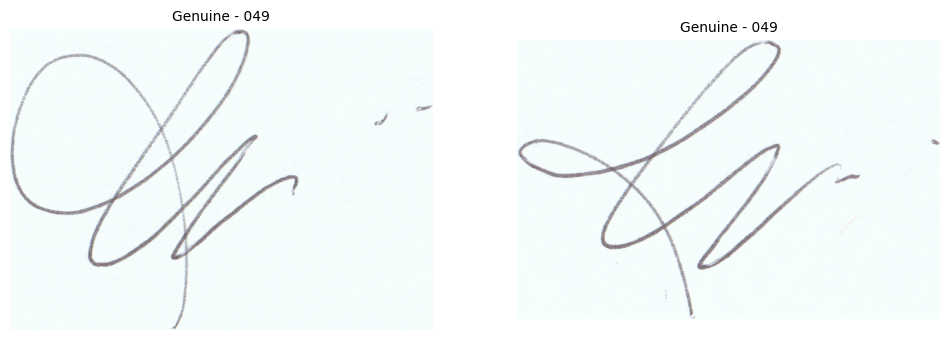

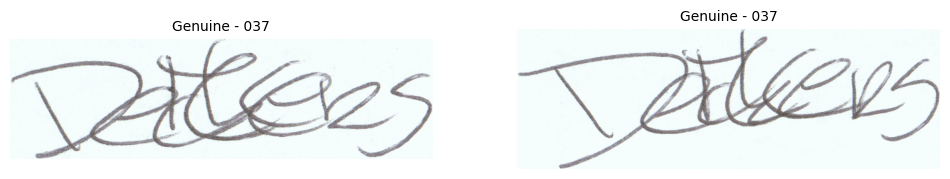

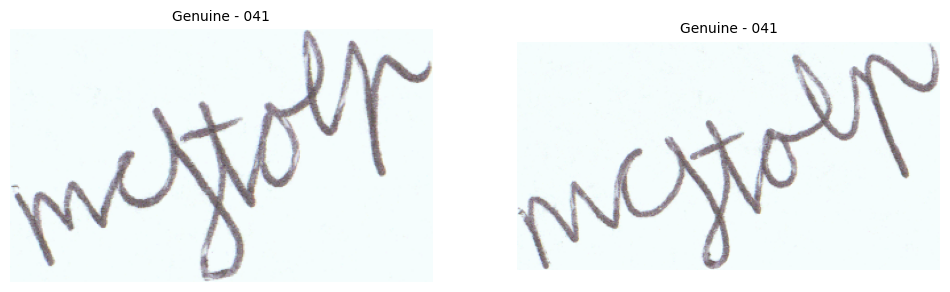

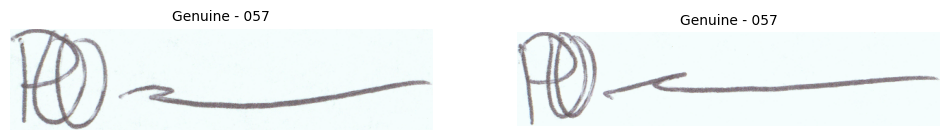

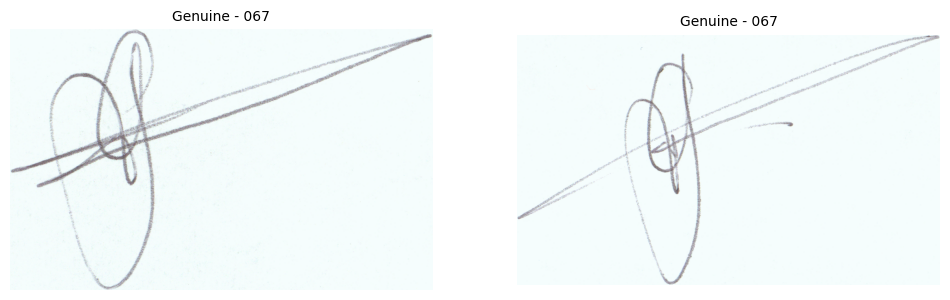

In [6]:


genuine_folders = sorted([f for f in os.listdir(dataset_path) if not f.endswith("_forg")])

selected_folders = random.sample(genuine_folders, 5)

for folder in selected_folders:
    images = []
    titles = []

    genuine_path = os.path.join(dataset_path, folder)
    forg_path = os.path.join(dataset_path, folder + "_forg")

    genuine_images = [f for f in os.listdir(genuine_path) if f.endswith(".png")]
    genuine_images = random.sample(genuine_images, min(2, len(genuine_images)))

    forg_images = [f for f in os.listdir(forg_path) if f.endswith(".png")]
    forg_images = random.sample(forg_images, min(2, len(forg_images)))

    for img_name in genuine_images:
        images.append(Image.open(os.path.join(genuine_path, img_name)))
        titles.append(f"Genuine - {folder}")

    for img_name in forg_images:
        images.append(Image.open(os.path.join(forg_path, img_name)))
        titles.append(f"Forged - {folder}")

    fig, axes = plt.subplots(1, len(images), figsize=(12, 5))
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap="gray")
        ax.set_title(title, fontsize=10)
        ax.axis("off")

    plt.show()

In [7]:
genuine_images_set = set()
forged_images_set = set()
image_dimensions_set = set()
total_number_of_training_examples = 0

for folder in genuine_folders:
    genuine_path = os.path.join(dataset_path, folder)
    forg_path = os.path.join(dataset_path, folder + "_forg")

    if os.path.exists(genuine_path):
        genuine_images_set.add(len(os.listdir(genuine_path)))

        for img in os.listdir(genuine_path):
            img_path = os.path.join(genuine_path, img)
            if img.endswith((".png", ".tif", ".jpg")):
                with Image.open(img_path) as im:
                    image_dimensions_set.add(im.size)

    else: print("Missing",genuine_path)

    if os.path.exists(forg_path):
        forged_images_set.add(len(os.listdir(forg_path)))

        for img in os.listdir(forg_path):
            img_path = os.path.join(forg_path, img)
            if img.endswith((".png", ".tif", ".jpg")):
                with Image.open(img_path) as im:
                    image_dimensions_set.add(im.size)

    else: print("Missing",forg_path)

    total_number_of_training_examples += len(os.listdir(genuine_path))*len(os.listdir(forg_path))

print(f"Total unique genuine images: {genuine_images_set}")
print(f"Total unique forged images: {forged_images_set}")
print("Total training examples:", total_number_of_training_examples)
print(f"Unique Shapes: len({image_dimensions_set})")

Total unique genuine images: {24, 12, 23}
Total unique forged images: {8, 11, 12, 16, 19, 20}
Total training examples: 10604
Unique Shapes: len({(410, 294), (605, 390), (736, 306), (521, 229), (321, 204), (783, 238), (653, 537), (314, 177), (627, 256), (601, 356), (613, 321), (842, 302), (550, 301), (650, 150), (740, 443), (468, 119), (1004, 242), (690, 204), (560, 113), (596, 286), (757, 203), (457, 347), (415, 103), (852, 239), (393, 201), (615, 375), (352, 172), (803, 346), (541, 108), (715, 233), (718, 406), (436, 162), (614, 187), (759, 425), (885, 272), (324, 366), (375, 179), (449, 217), (817, 393), (667, 296), (1026, 405), (976, 386), (680, 244), (1296, 485), (600, 144), (781, 165), (805, 284), (774, 278), (754, 458), (646, 367), (1221, 320), (603, 396), (757, 225), (647, 341), (812, 399), (589, 507), (712, 321), (415, 107), (471, 133), (806, 352), (494, 336), (657, 143), (720, 190), (645, 434), (287, 299), (503, 341), (804, 180), (482, 138), (653, 127), (714, 143), (619, 134),

In [8]:
widths = [dim[0] for dim in image_dimensions_set]
heights = [dim[1] for dim in image_dimensions_set]

width_mean = np.mean(widths)
height_mean = np.mean(heights)

width_median = median(widths)
height_median = median(heights)

try:
    width_mode = mode(widths)
except:
    width_mode = "No unique mode"

try:
    height_mode = mode(heights)
except:
    height_mode = "No unique mode"

print(f"Width - Mean: {width_mean}, Median: {width_median}, Mode: {width_mode}")
print(f"Height - Mean: {height_mean}, Median: {height_median}, Mode: {height_mode}")

Width - Mean: 653.8571428571429, Median: 650.0, Mode: 631
Height - Mean: 277.61948051948053, Median: 267.0, Mode: 257


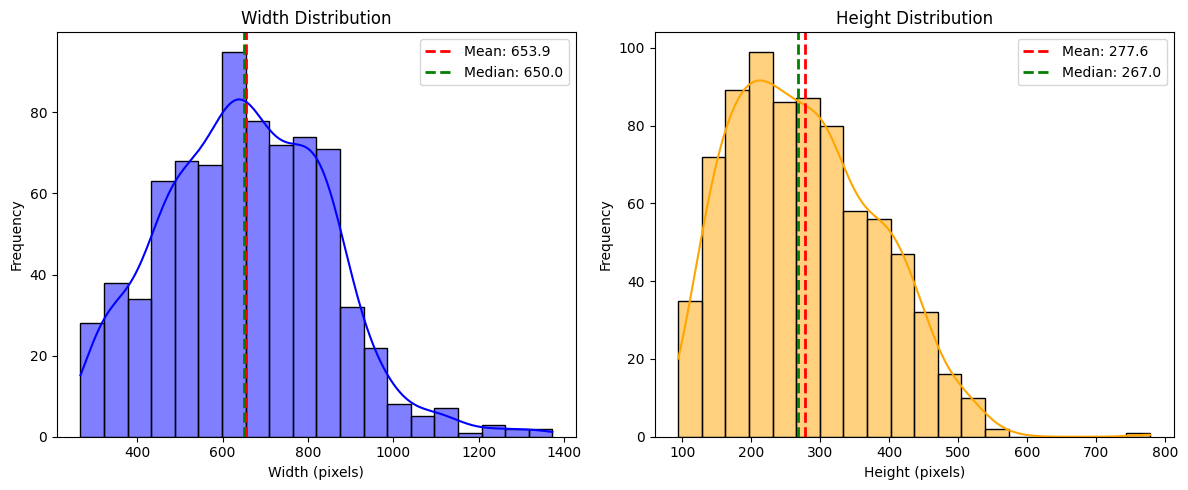

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(widths, kde=True, bins=20, color="blue")
plt.axvline(np.mean(widths), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {np.mean(widths):.1f}")
plt.axvline(median(widths), color='green', linestyle='dashed', linewidth=2, label=f"Median: {median(widths):.1f}")
plt.title("Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(heights, kde=True, bins=20, color="orange")
plt.axvline(np.mean(heights), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {np.mean(heights):.1f}")
plt.axvline(median(heights), color='green', linestyle='dashed', linewidth=2, label=f"Median: {median(heights):.1f}")
plt.title("Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

##Creating DataLoader

In [10]:
class SignatureDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.pairs = []

        individuals = os.listdir(root_dir)

        for person in individuals:
            person_dir = os.path.join(root_dir, person)

            genuine_path = None
            forged_path = None

            if "_forg" in person:
                continue

            genuine_path = os.path.join(root_dir, person)
            forged_path = os.path.join(root_dir, person + "_forg")

            if not os.path.exists(genuine_path) or not os.path.exists(forged_path):
                continue

            genuine_signs = sorted(os.listdir(genuine_path))
            forged_signs = sorted(os.listdir(forged_path))

            if len(genuine_signs) < 2 or len(forged_signs) < 1:
                continue

            for i in range(len(genuine_signs) - 1):
                for j in range(i + 1, len(genuine_signs)):
                    self.pairs.append((os.path.join(genuine_path, genuine_signs[i]),
                                       os.path.join(genuine_path, genuine_signs[j]), 1))

            for i in range(len(genuine_signs)):
                for j in range(len(forged_signs)):
                    self.pairs.append((os.path.join(genuine_path, genuine_signs[i]),
                                       os.path.join(forged_path, forged_signs[j]), 0))

        random.shuffle(self.pairs)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]

        img1 = Image.open(img1_path).convert("L")
        img2 = Image.open(img2_path).convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [11]:
TARGET_SIZE = (270, 650)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

obj = SignatureDataset("signature_data/signaturedataset2/sign_data/train",transform = transform)
print(f"NUMBER OF TRAIN EXAMPLES: {len(obj)}")

NUMBER OF TRAIN EXAMPLES: 16905


In [12]:
def get_signature_dataloader(root_dir, batch_size=32, train_split=0.8):

    TARGET_SIZE = (270, 650)

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(TARGET_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = SignatureDataset(root_dir, transform=transform)

    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size

    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader

In [13]:
class SiameseNetwork(nn.Module):
    def __init__(self):

        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=9, stride=1, padding=4),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(20, 40, kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(40, 80, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(80, 160, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Dropout2d(p=0.2),
        )


        self.fc1 = nn.Sequential(
            nn.Linear(2560, 640),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(640, 160),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(160,40),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(40,10)
        )

    def _get_flattened_size(self, x):

        x = self.cnn1(x)
        return x.view(x.size(0), -1).shape[1]

    def forward_once(self, x):

        x = self.cnn1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    def forward(self, input1, input2):

        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        epsilon = 1e-8
        dist = torch.sqrt(dist_sq+epsilon)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=epsilon)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [14]:
def show_plot(counter, loss):
    plt.plot(counter, loss)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Contrastive Loss Over Time')
    plt.show()

### TRAINING MODEL

In [19]:
net = SiameseNetwork().cuda()

criterion = ContrastiveLoss()

optimizer = optim.Adam(net.parameters(), lr=5e-4, weight_decay=0.0005)

def train(epochs=8, patience=5):
    loss_values = []
    counter = []
    iteration_number = 0

    best_val_loss = float("inf")
    best_model_state = None
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        net.train()
        epoch_loss = 0.0

        for img0, img1, label in train_loader:
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)

            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

            epoch_loss += loss_contrastive.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch} | Training Loss: {avg_epoch_loss:.4f}")

        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for img0, img1, label in val_loader:
                img0, img1, label = img0.to(device), img1.to(device), label.to(device)
                output1, output2 = net(img0, img1)
                loss_contrastive = criterion(output1, output2, label)
                val_loss += loss_contrastive.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch} | Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = net.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

        iteration_number += 16
        counter.append(iteration_number)
        loss_values.append(avg_epoch_loss)



    if best_model_state:
        torch.save(best_model_state, "best_model.pt")
        print("Best Model Saved Successfully")

    show_plot(counter, loss_values)

    return net


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root_dir = dataset_path
train_loader, val_loader = get_signature_dataloader(root_dir, batch_size=16, train_split=0.8)

Epoch 1 | Training Loss: 0.0092
Epoch 1 | Validation Loss: 0.0030
Epoch 2 | Training Loss: 0.0079
Epoch 2 | Validation Loss: 0.0035
Epoch 3 | Training Loss: 0.0074
Epoch 3 | Validation Loss: 0.0070
Epoch 4 | Training Loss: 0.0076
Epoch 4 | Validation Loss: 0.0052
Epoch 5 | Training Loss: 0.0079
Epoch 5 | Validation Loss: 0.0035
Epoch 6 | Training Loss: 0.0073
Epoch 6 | Validation Loss: 0.0033
Early stopping triggered after 6 epochs.
Best Model Saved Successfully


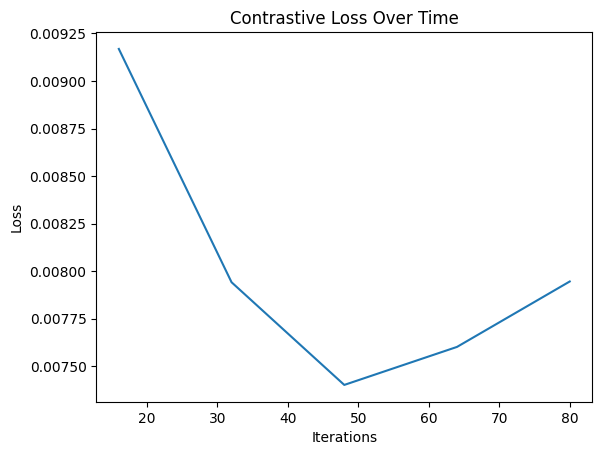

In [22]:
model = train()
torch.save(model.state_dict(), "model_weights.pt")

In [23]:
torch.save(model.state_dict(), 'model_weights.pt')

In [24]:
def evaluate_and_plot(model, val_loader):
    euclidean_distances = []
    actual_labels = []

    with torch.no_grad():  # No need to compute gradients during inference
        for img1, img2, label in val_loader:
            # Send data to GPU if using CUDA
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

            # Forward pass: get the outputs of the two images
            output1, output2 = model(img1, img2)

            # Compute the Euclidean distance between the output embeddings
            euclidean_distance = torch.sqrt(torch.sum((output1 - output2) ** 2, dim=1))

            # Append the distances and the actual labels
            euclidean_distances.extend(euclidean_distance.cpu().numpy())  # Move distances to CPU
            actual_labels.extend(label.cpu().numpy())  # Move labels to CPU

    return euclidean_distances, actual_labels

In [27]:
model_weights_dir = "best_model.pt"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root_dir = dataset_path
train_loader, val_loader = get_signature_dataloader(root_dir, batch_size=16, train_split=0.8)

model = SiameseNetwork().to(device)
model.load_state_dict(torch.load(model_weights_dir))
model.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): Conv2d(20, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (6): ReLU(inplace=True)
    (7): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.2, inplace=False)
    (10): Conv2d(40, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): ReLU(inplace=True)
    (12): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.2, inplace=False)
    (15): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(in

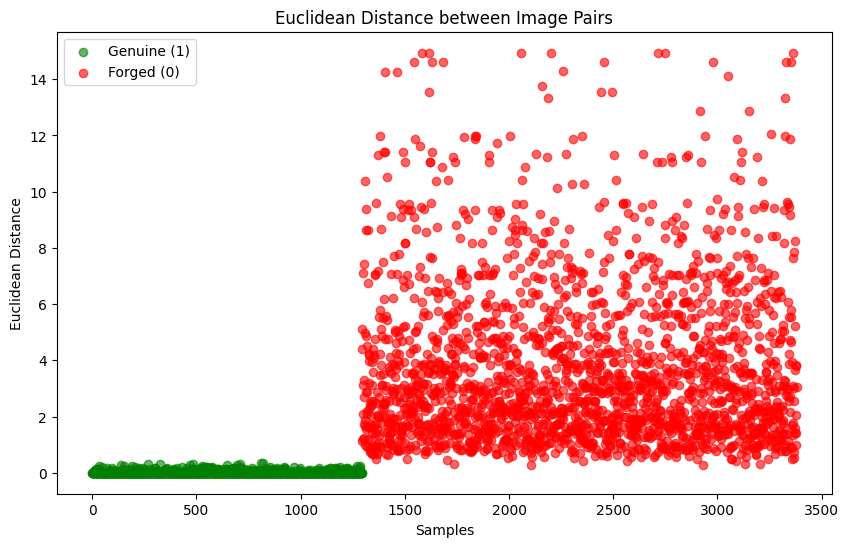

In [28]:
euclidean_distances, actual_labels = evaluate_and_plot(model, val_loader)

# Plot the Euclidean distances with actual labels as the legend
def plot_distances(euclidean_distances, actual_labels):
    plt.figure(figsize=(10, 6))

    # Plot genuine (label=1) and forged (label=0) distances
    genuine_distances = [d for d, label in zip(euclidean_distances, actual_labels) if label == 1]
    forged_distances = [d for d, label in zip(euclidean_distances, actual_labels) if label == 0]

    plt.scatter([i for i in range(len(genuine_distances))], genuine_distances, color='g', label='Genuine (1)', alpha=0.6)
    plt.scatter([i + len(genuine_distances) for i in range(len(forged_distances))], forged_distances, color='r', label='Forged (0)', alpha=0.6)

    plt.xlabel("Samples")
    plt.ylabel("Euclidean Distance")
    plt.title("Euclidean Distance between Image Pairs")
    plt.legend()
    plt.show()

# Plot the graph
plot_distances(euclidean_distances, actual_labels)

Top 10 highest distances for label 1 (genuine):
1. 0.3283272981643677
2. 0.3283272981643677
3. 0.3261820375919342
4. 0.29812610149383545
5. 0.298118531703949
6. 0.29786795377731323
7. 0.2889351546764374
8. 0.28892427682876587
9. 0.28778770565986633
10. 0.28738293051719666

Top 10 lowest distances for label 0 (forged):
1. 0.2804102301597595
2. 0.2804102301597595
3. 0.30611300468444824
4. 0.30611300468444824
5. 0.30611300468444824
6. 0.4124734401702881
7. 0.4128876328468323
8. 0.4129197299480438
9. 0.4437224864959717
10. 0.47966647148132324


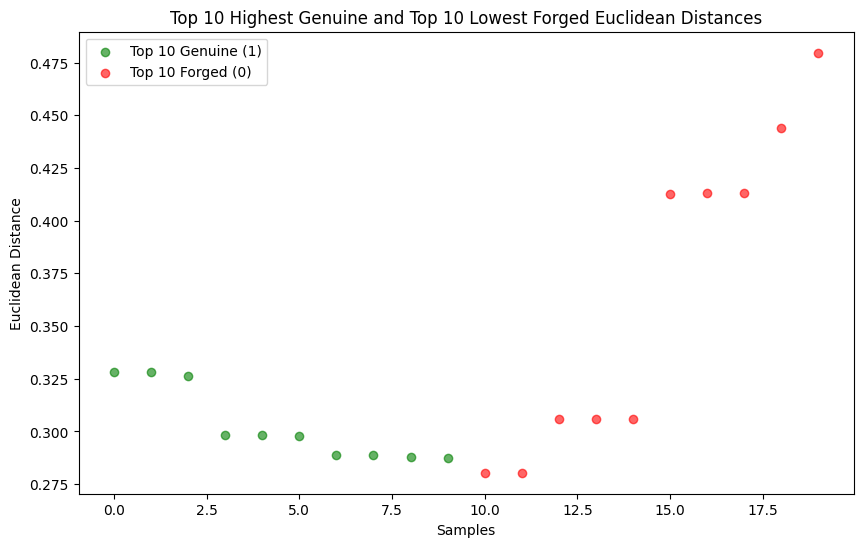

In [29]:
# Extract distances based on labels
genuine_distances = [d for d, label in zip(euclidean_distances, actual_labels) if label == 1]
forged_distances = [d for d, label in zip(euclidean_distances, actual_labels) if label == 0]

# Get the 10 highest distances for label 1 (genuine) and 10 lowest distances for label 0 (forged)
top_10_genuine = sorted(genuine_distances, reverse=True)[:10]
top_10_forged = sorted(forged_distances)[:10]

# Display the results
print("Top 10 highest distances for label 1 (genuine):")
for i, dist in enumerate(top_10_genuine):
    print(f"{i+1}. {dist}")

print("\nTop 10 lowest distances for label 0 (forged):")
for i, dist in enumerate(top_10_forged):
    print(f"{i+1}. {dist}")

def plot_selected_distances(genuine_distances, forged_distances):
    plt.figure(figsize=(10, 6))

    # Plot the 10 highest genuine distances (label=1) and 10 lowest forged distances (label=0)
    plt.scatter([i for i in range(len(top_10_genuine))], top_10_genuine, color='g', label='Top 10 Genuine (1)', alpha=0.6)
    plt.scatter([i + len(top_10_genuine) for i in range(len(top_10_forged))], top_10_forged, color='r', label='Top 10 Forged (0)', alpha=0.6)

    # Adding labels and title
    plt.xlabel("Samples")
    plt.ylabel("Euclidean Distance")
    plt.title("Top 10 Highest Genuine and Top 10 Lowest Forged Euclidean Distances")
    plt.legend()
    plt.show()

# Plot the selected distances
plot_selected_distances(top_10_genuine, top_10_forged)

In [30]:
test_dir = 'signature_data/signaturedataset2/sign_data/test'
def get_signature_test_dataloader(root_dir, batch_size=32):
    TARGET_SIZE = (270, 650)

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(TARGET_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = SignatureDataset(root_dir, transform=transform)

    # Create a DataLoader for the entire dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    return dataloader

test_loader = get_signature_test_dataloader(test_dir)

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
def evaluate_and_plot(model, val_loader, distance_threshold=0.25):
    euclidean_distances = []
    actual_labels = []
    predicted_labels = []

    with torch.no_grad():  # No need to compute gradients during inference
        for img1, img2, label in val_loader:
            # Send data to GPU if using CUDA
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

            # Forward pass: get the outputs of the two images
            output1, output2 = model(img1, img2)

            # Compute the Euclidean distance between the output embeddings
            euclidean_distance = torch.sqrt(torch.sum((output1 - output2) ** 2, dim=1))

            # Predict label: 1 if distance <= threshold, else 0
            pred_label = (euclidean_distance <= distance_threshold).long()

            # Append the distances, actual labels, and predicted labels
            euclidean_distances.extend(euclidean_distance.cpu().numpy())  # Move distances to CPU
            actual_labels.extend(label.cpu().numpy())  # Move labels to CPU
            predicted_labels.extend(pred_label.cpu().numpy())  # Move predictions to CPU

    # Calculate the confusion matrix
    cm = confusion_matrix(actual_labels, predicted_labels)

    # Calculate performance metrics
    accuracy = accuracy_score(actual_labels, predicted_labels)
    precision = precision_score(actual_labels, predicted_labels)
    recall = recall_score(actual_labels, predicted_labels)
    f1 = f1_score(actual_labels, predicted_labels)

    # Print performance metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return euclidean_distances, actual_labels, predicted_labels, cm


def plot_confusion_matrix(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Forged', 'Genuine'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


def plot_distances(euclidean_distances, actual_labels, predicted_labels):
    plt.figure(figsize=(10, 6))

    # Plot genuine (label=1) and forged (label=0) distances, color by predicted label
    genuine_distances = [d for d, label in zip(euclidean_distances, actual_labels) if label == 1]
    forged_distances = [d for d, label in zip(euclidean_distances, actual_labels) if label == 0]

    genuine_preds = [d for d, label in zip(euclidean_distances, predicted_labels) if label == 1]
    forged_preds = [d for d, label in zip(euclidean_distances, predicted_labels) if label == 0]

    # Genuine vs Forged distances
    plt.scatter(range(len(genuine_distances)), genuine_distances, color='g', label='Genuine (1)', alpha=0.6)
    plt.scatter(range(len(forged_distances)), forged_distances, color='r', label='Forged (0)', alpha=0.6)

    # Predicted distances for genuine and forged
    plt.scatter(range(len(genuine_preds), len(genuine_preds) + len(forged_preds)), genuine_preds, color='b', label='Predicted Genuine', alpha=0.6)
    plt.scatter(range(len(forged_preds), len(forged_preds) + len(genuine_preds)), forged_preds, color='orange', label='Predicted Forged', alpha=0.6)

    plt.xlabel("Samples")
    plt.ylabel("Euclidean Distance")
    plt.title("Euclidean Distance between Image Pairs")
    plt.legend()
    plt.show()

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


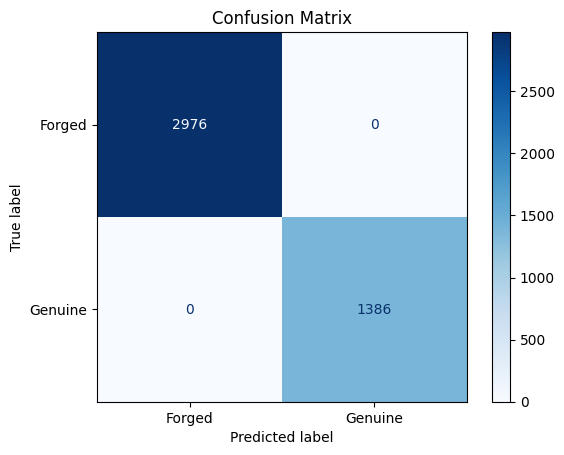

In [35]:
euclidean_distances, actual_labels, predicted_labels, cm = evaluate_and_plot(model, test_loader, distance_threshold=0.25)

# Plot the confusion matrix
plot_confusion_matrix(cm)

In [36]:
model = SiameseNetwork()
model.load_state_dict(torch.load("best_model.pt"))
model.eval() # Set the model to evaluation mode

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): Conv2d(20, 40, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (6): ReLU(inplace=True)
    (7): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.2, inplace=False)
    (10): Conv2d(40, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): ReLU(inplace=True)
    (12): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.2, inplace=False)
    (15): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(in